In [79]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import regionmask
import geopandas as gpd
from joblib import Parallel, delayed
import xarray as xr
import os

Analisando os resultados do banco criado

In [80]:
def coletando_dados(n, mask, lon, lat):
    # print(n)
    delta_lon = 0
    lon_municipios, lat_municipios = municipios_centroid_x[n], municipios_centroid_y[n]
    sel_mask = mask.where(mask == n).values
    id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
    if len(id_lon) >= 1:
        id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
        out_sel = var.sel(lat=slice(id_lat[0], id_lat[-1]),
                                               lon=slice(id_lon[0], id_lon[-1])).compute().where(mask == n)

        out_sel = np.nanmean(out_sel.values, axis=(1, 2))

    else:
        out_sel = var.sel(lat=lat_municipios,
                                               lon=lon_municipios,
                                               method='nearest')

    while np.isnan(out_sel[0]):
        print(n)
        out_sel = var.sel(lat=lat_municipios,
                lon=lon_municipios + delta_lon,
                method='nearest').values
        delta_lon += -0.1

    municipios_data_pandas = out_sel

    return municipios_data_pandas

In [81]:
municipios = gpd.read_file('../malha2022/Brazil_2022.shp')
municipios['code_mn'] = municipios['code_mn'].astype(int)
municipios.head(4)

code_mn                name_mn  cod_stt abbrv_s   nam_stt  cod_rgn nam_rgn  \
0  1100015  Alta Floresta D'oeste     11.0      RO  Rondônia      1.0   Norte   
1  1100023              Ariquemes     11.0      RO  Rondônia      1.0   Norte   
2  1100031                 Cabixi     11.0      RO  Rondônia      1.0   Norte   
3  1100049                 Cacoal     11.0      RO  Rondônia      1.0   Norte   

                                            geometry  
0  POLYGON ((-61.96836 -12.13407, -62.00806 -12.1...  
1  POLYGON ((-63.18281 -10.13892, -63.17933 -10.1...  
2  POLYGON ((-60.70518 -13.32474, -60.52408 -13.3...  
3  POLYGON ((-61.3474 -11.50562, -61.35502 -11.50...

https://www.ibge.gov.br/explica/codigos-dos-municipios.php

In [82]:
municipios = municipios[municipios['code_mn'].isin([2611606])]
municipios

code_mn name_mn  cod_stt abbrv_s     nam_stt  cod_rgn   nam_rgn  \
1596  2611606  Recife     26.0      PE  Pernambuco      2.0  Nordeste   

                                               geometry  
1596  POLYGON ((-34.91359 -8.14512, -34.918 -8.1431,...

In [83]:
arqs_nc = os.listdir("../modelos_cmip")
arqs_nc

['tasmax_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_185001-185012.nc',
 'tasmin_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_185001-185012.nc']

In [84]:
elementos = [item.split("_")[0] for item in arqs_nc]
elementos

['tasmax', 'tasmin']

CMIP: https://aims2.llnl.gov/search/cmip6/ 

Variáveis: https://airtable.com/appYNLuWqAgzLbhSq/shrgcENhJZU1y3ye0/tbleXPCaJeYeIzAhR

Cenários: https://www.dkrz.de/en/communication/climate-simulations/cmip6-en/the-ssp-scenarios

In [85]:
nvar2get = elementos[0]

# caminho dos arquivos NetCDF da grade BR-DWGD (COLOCAR O CAMINHO CORRETO)
var = xr.open_dataset('../modelos_cmip/{}'.format(arqs_nc[0]))[nvar2get]

if len(var.dims) == 4 and 'lev' in var.dims:
    var = var.isel(lev=0)

var

<xarray.DataArray 'tasmax' (time: 12, lat: 256, lon: 512)> Size: 6MB
[1572864 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 96B 1850-01-16T12:00:00 ... 1850-12-16T12:...
  * lat      (lat) float64 2kB -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
    height   float64 8B ...
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    units:          K
    cell_methods:   area: mean time: maximum within days time: mean over days
    cell_measures:  area: areacella
    history:        2020-05-02T03:03:03Z altered by CMOR: Treated scalar dime...

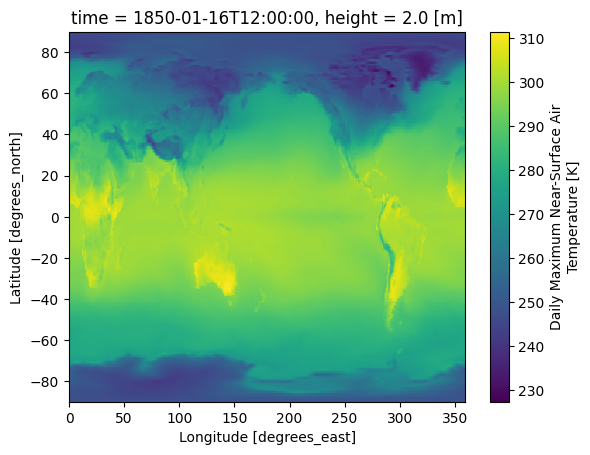

In [86]:
plt.figure()
img = var.isel(time=0).plot()
plt.savefig("../graficos/calor_var_time0.png", format='png')
plt.show()

In [87]:
# centróides dos municípios para serem utilizados quando
# o município é muito pequeno e não há célula da grade dentro.
# Vai pegar da célula mais próxima ao centroide do município
municipios_centroid_x = municipios.to_crs(epsg=5641).centroid.to_crs(municipios.crs).x.values
municipios_centroid_y = municipios.to_crs(epsg=5641).centroid.to_crs(municipios.crs).y.values

# mascara dos municípios
municipios_mask_poly = regionmask.Regions(name="municipios_mask",
                                          numbers=list(range(len(municipios))),
                                          names=list(municipios.code_mn),
                                          outlines=list(municipios.geometry.values[i] for i in range(len(municipios))))

municipios_mask_poly.overlap = False
mask_munic = municipios_mask_poly.mask(var['lon'].values, var['lat'].values)

print("Extraindo dados dos municípios")
lat = mask_munic.lat.values
lon = mask_munic.lon.values

start = time.time()
saida = Parallel(n_jobs=-1, verbose=4)(delayed(coletando_dados)(n, mask_munic, lon, lat)
                                       for n in range(len(municipios.code_mn)))
print(f'tempo: {time.time() - start}')

municipios_data = pd.DataFrame(np.empty((len(municipios.code_mn),
                                         len(var.time)), dtype="float"),
                               columns=var.time.dt.strftime('%Y-%m-%d'),
                               index=municipios.index)

for n in range(len(saida)):
    municipios_data.iloc[n, :] = saida[n]

# concatenado dados shape com dados da grade reamostrados
municipios_data.set_index(municipios.index, inplace=True)
municipios = pd.concat((municipios, municipios_data), axis=1)

Extraindo dados dos municípios
tempo: 0.03360271453857422


c:\Users\malco\AppData\Local\Programs\Python\Python312\Lib\site-packages\regionmask\core\_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [88]:
municipios.head(4)

code_mn name_mn  cod_stt abbrv_s     nam_stt  cod_rgn   nam_rgn  \
1596  2611606  Recife     26.0      PE  Pernambuco      2.0  Nordeste   

                                               geometry  1850-01-16  \
1596  POLYGON ((-34.91359 -8.14512, -34.918 -8.1431,...  299.565796   

      1850-02-15  1850-03-16  1850-04-16  1850-05-16  1850-06-16  1850-07-16  \
1596  299.787537  300.734985  301.117554  300.134979  298.599976  297.074127   

      1850-08-16  1850-09-16  1850-10-16  1850-11-16  1850-12-16  
1596  296.102509  295.968201  296.609863  297.831085  298.939514

<Figure size 2000x1600 with 0 Axes>

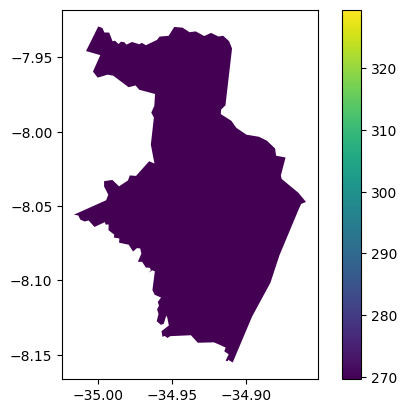

In [89]:
plt.figure(figsize=(20, 16))
municipios.plot('1850-01-16', legend=True)

plt.savefig("../graficos/municipio_var_time0.png", format='png')
plt.show()

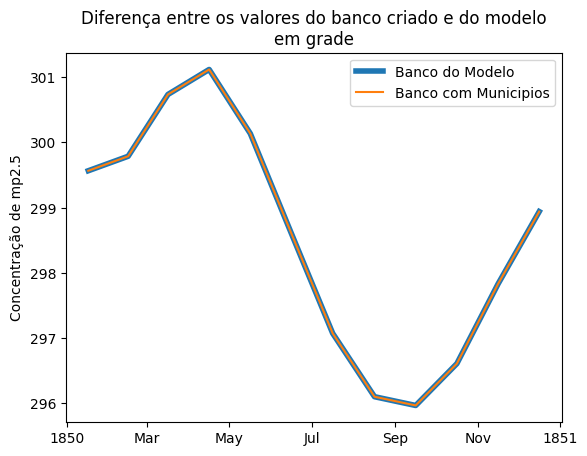

In [90]:
n = 0
plt.figure()
lon_municipios, lat_municipios = municipios_centroid_x[n], municipios_centroid_y[n]

var.sel(lat=lat_municipios, lon=lon_municipios, method='nearest').plot(label='Banco do Modelo', linewidth=4)
plt.plot(var.time, municipios.iloc[n, 8:], label='Banco com Municipios')

plt.xlabel("")
plt.ylabel("Concentração de mp2.5")
plt.title("Diferença entre os valores do banco criado e do modelo\nem grade")

plt.savefig("../graficos/comparativo_banco_modelo.png", format='png')

plt.legend()
